# Traffic Signs Detection



In [8]:
#from google.colab import drive
#drive.mount('/content/drive')

In [9]:
# !unzip /content/drive/MyDrive/traffic.zip

In [10]:
# Directories where training and testing datasets located
PATH = '/content/Dataset'
TESTING_PATH = '/content/Dataset/Test'
# Minimal number of samples for each class for data augmentation 
MIN_IMGS_IN_CLASS = 500
# Learning parameters
EPOCHS = 100
INIT_LR = 0.001
BATCH_SIZE = 256
SET_DECAY = True



### Imports

In [11]:
import random
import csv
import cv2 as cv
import numpy as np
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

### Load data

At first, we need to load testing data from the directory it is stored

In [12]:
images = [] # images
labels = [] # corresponding labels

# loop over all 43 classes
gtFile = open(PATH + '/Train.csv') # annotations file
gtReader = csv.reader(gtFile, delimiter=',') # csv parser for annotations file
next(gtReader) # skip header
# loop over all images in current annotations file
for row in gtReader:
    img = cv.imread(PATH + '/' + row[7])
    images.append(cv.resize(img, (28, 28)))
    labels.append(row[6]) # the 6th column is the label
gtFile.close()

Check what we loaded

In [13]:
print('Number of loaded images: ' + str(len(images)))
print('Number of loaded labels: ' + str(len(labels)))



Number of loaded images: 39209
Number of loaded labels: 39209


Let's convert arrays of labels and images to np arrays to simplify further manipulations

In [14]:
train_X = np.asarray(images)
train_X = train_X / 255
train_X = np.asarray(train_X, dtype = "float32")
train_Y = np.asarray(labels, dtype= "float32")

So, now we have an array of shape:

In [15]:
print('Shape of training array: ' + str(train_X.shape))



Shape of training array: (39209, 28, 28, 3)


Let's check how much classes we have and how much images in training set we have for each class

In [16]:
def count_images_in_classes(lbls):
    dct = {}
    for i in lbls:
        if i in dct:
            dct[i] += 1
        else:
            dct[i] = 1
    return dct

In [17]:
samples_distribution = count_images_in_classes(train_Y)
print(samples_distribution)

{20.0: 360, 0.0: 210, 1.0: 2220, 2.0: 2250, 3.0: 1410, 4.0: 1980, 5.0: 1860, 6.0: 420, 7.0: 1440, 8.0: 1410, 9.0: 1470, 10.0: 2010, 11.0: 1320, 12.0: 2100, 13.0: 2160, 14.0: 780, 15.0: 630, 16.0: 420, 17.0: 1110, 18.0: 1200, 19.0: 210, 21.0: 330, 22.0: 390, 23.0: 510, 24.0: 270, 25.0: 1500, 26.0: 600, 27.0: 240, 28.0: 540, 29.0: 270, 30.0: 450, 31.0: 780, 32.0: 240, 33.0: 689, 34.0: 420, 35.0: 1200, 36.0: 390, 37.0: 210, 38.0: 2070, 39.0: 300, 40.0: 360, 41.0: 240, 42.0: 240}


In [18]:
def distribution_diagram(dct):
    plt.bar(range(len(dct)), list(dct.values()), align='center')
    plt.xticks(range(len(dct)), list(dct.keys()), rotation=90, fontsize=7)
    plt.show()

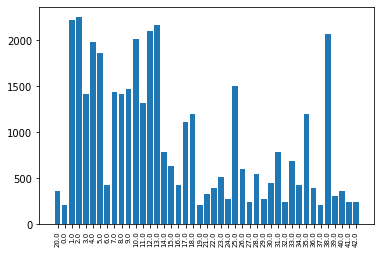

In [19]:
distribution_diagram(samples_distribution)

Plot one image from each class to better understand the data

In [20]:
def preview(images, labels):
    plt.figure(figsize=(16, 16))
    for c in range(len(np.unique(labels))):
        i = random.choice(np.where(labels == c)[0])
        plt.subplot(10, 10, c+1)
        plt.axis('off')
        plt.title('class: {}'.format(c))
        plt.imshow(images[i])

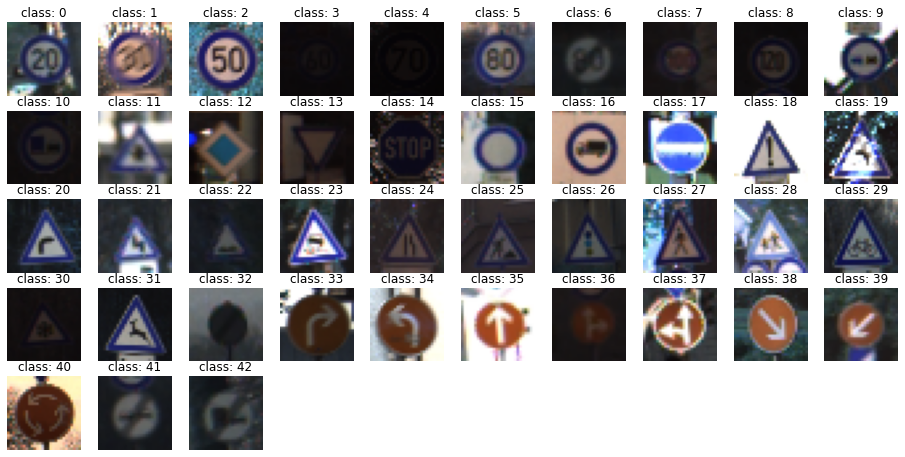

In [21]:
preview(train_X, train_Y)


Now, we can find that the training dataset is not well-balanced, but we can deal with this fact using data augmentation technique

In [22]:
def augment_imgs(imgs, p,imgaug=None):
    """
    Performs a set of augmentations with with a probability p
    """
    from imgaug import augmenters as iaa
    augs =  iaa.SomeOf((2, 4),
          [
              iaa.Crop(px=(0, 4)), # crop images from each side by 0 to 4px (randomly chosen)
              iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}),
              iaa.Affine(translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
              iaa.Affine(rotate=(-45, 45)), # rotate by -45 to +45 degrees)
              iaa.Affine(shear=(-10, 10)) # shear by -10 to +10 degrees
          ])
    
    seq = iaa.Sequential([iaa.Sometimes(p, augs)])
    res = seq.augment_images(imgs)
    return res

In [23]:
def augmentation(imgs, lbls):
    classes = count_images_in_classes(lbls)
    for i in range(len(classes)):
        if (classes[i] < MIN_IMGS_IN_CLASS):
            # Number of samples to be added
            add_num = MIN_IMGS_IN_CLASS - classes[i]
            imgs_for_augm = []
            lbls_for_augm = []
            for j in range(add_num):
                im_index = random.choice(np.where(lbls == i)[0])
                imgs_for_augm.append(imgs[im_index])
                lbls_for_augm.append(lbls[im_index])
            augmented_class = augment_imgs(imgs_for_augm, 1)
            augmented_class_np = np.array(augmented_class)
            augmented_lbls_np = np.array(lbls_for_augm)
            imgs = np.concatenate((imgs, augmented_class_np), axis=0)
            lbls = np.concatenate((lbls, augmented_lbls_np), axis=0)
    return (imgs, lbls)

In [24]:
train_X, train_Y = augmentation(train_X, train_Y)

After augmentation our training dataset has the folowing shape:

In [25]:
print(train_X.shape)
print(train_Y.shape)

(42739, 28, 28, 3)
(42739,)


Let's check data distribution again

In [26]:
augmented_samples_distribution = count_images_in_classes(train_Y)
print(augmented_samples_distribution)

{20.0: 500, 0.0: 500, 1.0: 2220, 2.0: 2250, 3.0: 1410, 4.0: 1980, 5.0: 1860, 6.0: 500, 7.0: 1440, 8.0: 1410, 9.0: 1470, 10.0: 2010, 11.0: 1320, 12.0: 2100, 13.0: 2160, 14.0: 780, 15.0: 630, 16.0: 500, 17.0: 1110, 18.0: 1200, 19.0: 500, 21.0: 500, 22.0: 500, 23.0: 510, 24.0: 500, 25.0: 1500, 26.0: 600, 27.0: 500, 28.0: 540, 29.0: 500, 30.0: 500, 31.0: 780, 32.0: 500, 33.0: 689, 34.0: 500, 35.0: 1200, 36.0: 500, 37.0: 500, 38.0: 2070, 39.0: 500, 40.0: 500, 41.0: 500, 42.0: 500}


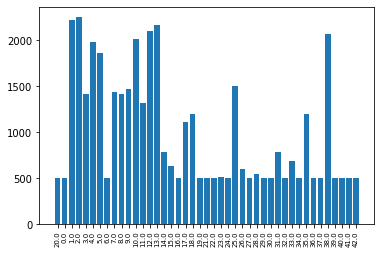

In [27]:
distribution_diagram(augmented_samples_distribution)

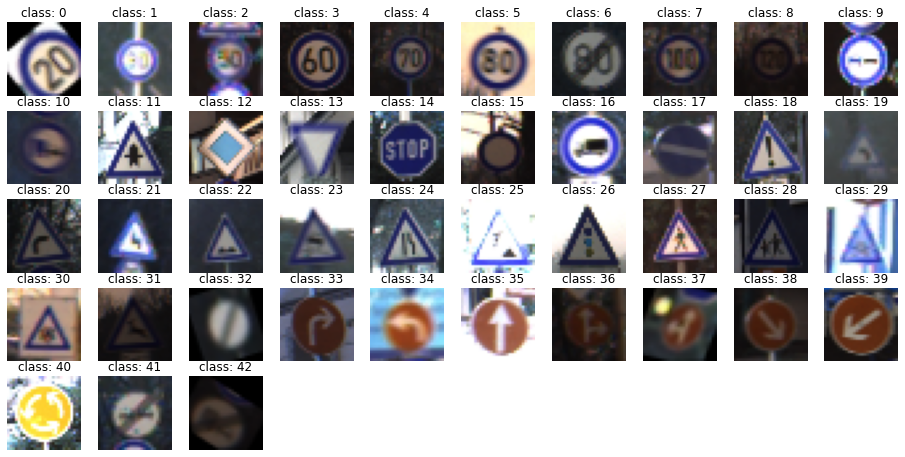

In [28]:
preview(train_X, train_Y)



Grayscale all images in order to improve efficiency of our neural classifier

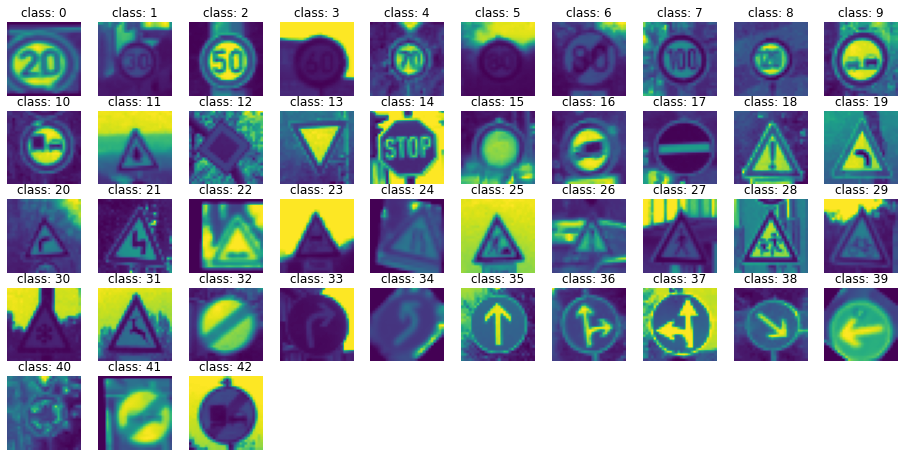

In [29]:
train_X = rgb2gray(train_X)
# preview(train_X, train_Y)



In [30]:
def build(width, height, depth, classes):
    # initialize the model along with the input shape to be
    # "channels last" and the channels dimension itself
    model = keras.Sequential()
    inputShape = (height, width, depth)
    chanDim = -1

    # CONV => RELU => BN => POOL
    model.add(Conv2D(8, (5, 5), padding="same", input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # first set of (CONV => RELU => CONV => RELU) * 2 => POOL
    model.add(Conv2D(16, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(16, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # second set of (CONV => RELU => CONV => RELU) * 2 => POOL
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # first set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # second set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    # return the constructed network architecture
    return model

In [31]:
model = build(28, 28, 1, 43)

In [32]:
if SET_DECAY == True:
    opt = Adam(lr=INIT_LR, decay=INIT_LR / (EPOCHS * 0.5))
else:
    opt = Adam(lr=INIT_LR)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])



In [33]:
test_images = [] # images
test_labels = [] # corresponding labels
test = '/content/Dataset'
# loop over all 43 classes
gtFile = open('/content/Dataset/Test.csv') # annotations file
gtReader = csv.reader(gtFile, delimiter=',') # csv parser for annotations file
next(gtReader) # skip header
# loop over all images in current annotations file
for row in gtReader:
    #print(PATH + row[7])
    img = cv.imread(PATH + '/'  + row[7])
    test_images.append(cv.resize(img, (28, 28)))
    test_labels.append(row[6]) # the 6th column is the label
gtFile.close()

In [34]:
test_X = np.asarray(test_images)
test_X = test_X / 255
test_X = np.asarray(test_X, dtype = "float32")

In [35]:
test_X = rgb2gray(test_X)
test_X.shape

(12630, 28, 28)

In [36]:
test_Y = np.asarray(test_labels, dtype = "float32")
test_Y.shape

(12630,)

In [37]:
print(train_X.shape)
train_X_ext = np.expand_dims(train_X, axis=3)
print(train_X_ext.shape)
print(train_Y.shape)
train_Y_ext = np.expand_dims(train_Y, axis=1)
print(train_Y_ext.shape)



(42739, 28, 28)
(42739, 28, 28, 1)
(42739,)
(42739, 1)


In [38]:
import os
with tf.device('/device:GPU:0'):
  os.mkdir("models_Xception")
  for i in range(EPOCHS):
    model.save("models_Xception/model_" + str(i) + ".h5")
    H = model.fit(train_X_ext, train_Y, epochs=1, batch_size=BATCH_SIZE)

167/167 [==============================] - 1s 7ms/step - loss: 0.0209 - accuracy: 0.9934


In [39]:
'''
with tf.device('/device:GPU:0'):
    os.mkdir("models_Xception")
    for i in range(epochs):
        generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
        model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
        model.save("models6/model_" + str(i) + ".h5")
'''

'\nwith tf.device(\'/device:GPU:0\'):\n    os.mkdir("models_Xception")\n    for i in range(epochs):\n        generator = data_generator(train_descriptions, train_features, tokenizer, max_length)\n        model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)\n        model.save("models6/model_" + str(i) + ".h5")\n'

In [40]:
'''
print(test_X.shape)
test_X_ext = np.expand_dims(test_X, axis=3)
print(test_X_ext.shape)
print(test_Y.shape)
test_Y_ext = np.expand_dims(test_Y, axis=3)
print(test_Y_ext.shape)
test_loss, test_acc = model.evaluate(test_X_ext,  test_Y_ext, verbose=1)
'''

'\nprint(test_X.shape)\ntest_X_ext = np.expand_dims(test_X, axis=3)\nprint(test_X_ext.shape)\nprint(test_Y.shape)\ntest_Y_ext = np.expand_dims(test_Y, axis=3)\nprint(test_Y_ext.shape)\ntest_loss, test_acc = model.evaluate(test_X_ext,  test_Y_ext, verbose=1)\n'

In [41]:
# print(H.history)

In [42]:
'''

'''

"\nplt.plot(H.history['accuracy'])\n#plt.plot(H.history['val_accuracy'])\nplt.title('Model accuracy')\nplt.ylabel('accuracy')\nplt.xlabel('epoch')\n#plt.legend(['train', 'test'], loc='upper left')\nplt.show()\n# summarize history for loss\nplt.plot(H.history['loss'])\n#plt.plot(H.history['val_loss'])\nplt.title('Model loss')\nplt.ylabel('loss')\nplt.xlabel('epoch')\n#plt.legend(['train', 'test'], loc='upper left')\nplt.show()\n"

In [43]:
# print(test_loss)

NameError: ignored

In [44]:
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 8)         208       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 8)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 8)         32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 16)        6

In [46]:
from keras.utils import plot_model



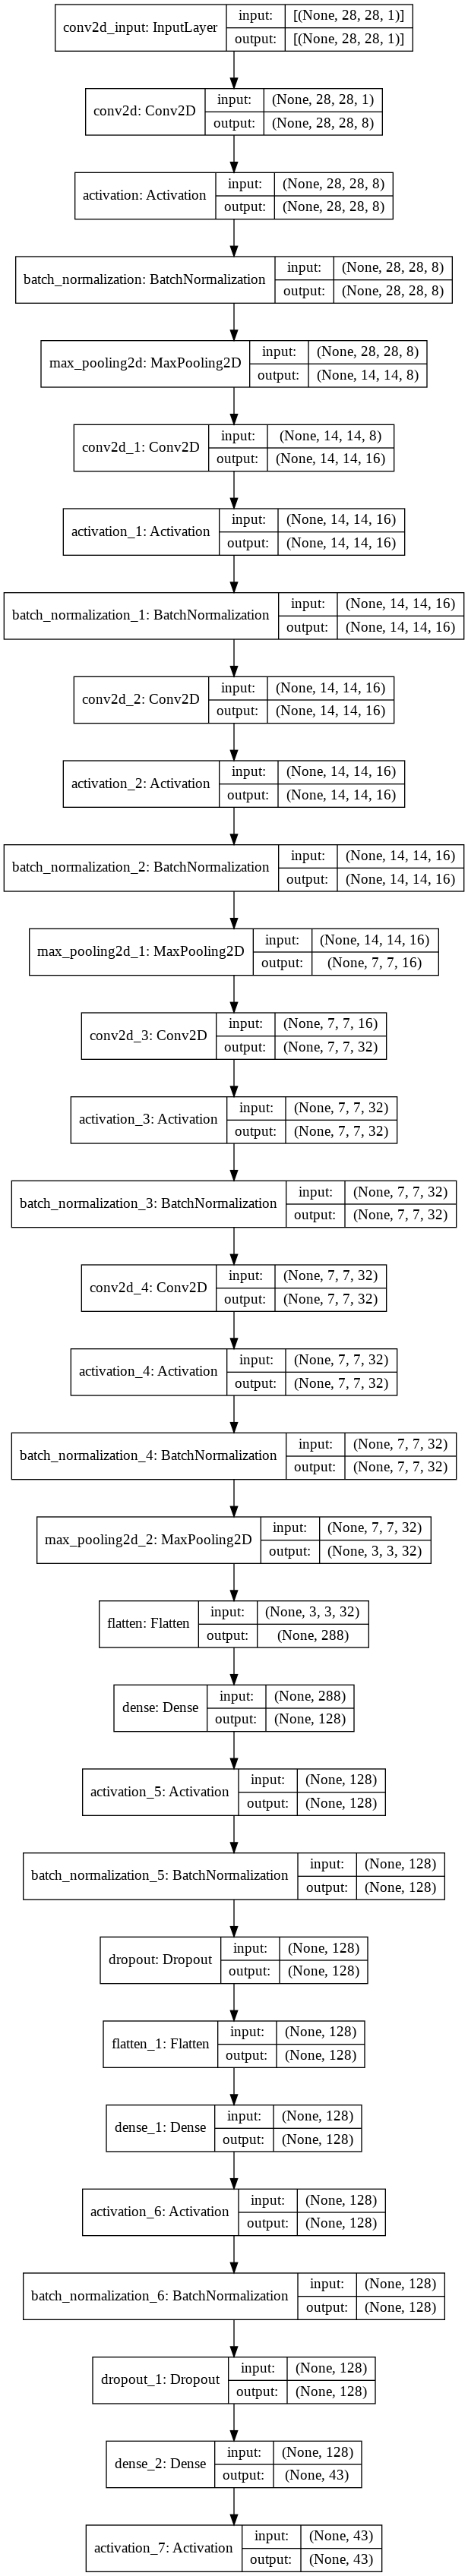

In [47]:
plot_model(model, to_file='/content/models_Xception/model.png', show_shapes=True)

In [50]:
model.save_weights('model_final.h5')

Epoch 1/100
167/167 [==============================] - 1s 8ms/step - loss: 0.0203 - accuracy: 0.9933
Epoch 2/100
167/167 [==============================] - 1s 7ms/step - loss: 0.0178 - accuracy: 0.9941
Epoch 3/100
167/167 [==============================] - 1s 7ms/step - loss: 0.0191 - accuracy: 0.9936
Epoch 4/100
167/167 [==============================] - 1s 7ms/step - loss: 0.0191 - accuracy: 0.9934
Epoch 5/100
167/167 [==============================] - 1s 7ms/step - loss: 0.0206 - accuracy: 0.9931
Epoch 6/100
167/167 [==============================] - 1s 7ms/step - loss: 0.0196 - accuracy: 0.9936
Epoch 7/100
167/167 [==============================] - 1s 7ms/step - loss: 0.0210 - accuracy: 0.9931
Epoch 8/100
167/167 [==============================] - 1s 7ms/step - loss: 0.0234 - accuracy: 0.9926
Epoch 9/100
167/167 [==============================] - 1s 7ms/step - loss: 0.0192 - accuracy: 0.9936
Epoch 10/100
167/167 [==============================] - 1s 7ms/step - loss: 0.0197 - accura

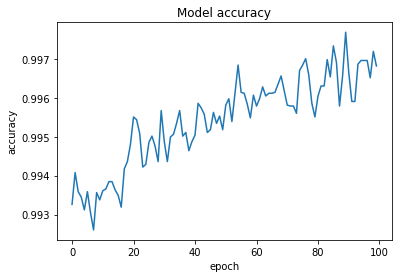

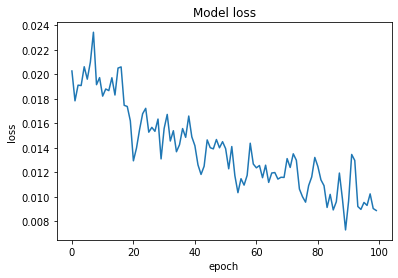

<Figure size 432x288 with 0 Axes>

In [54]:
M = model.fit(train_X_ext, train_Y, epochs=EPOCHS, batch_size=BATCH_SIZE)
plt.plot(M.history['accuracy'])
#plt.plot(H.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('accuracy.png')
# summarize history for loss
plt.plot(M.history['loss'])
#plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('loss.png')

In [ ]:
!zip -r /content/model.zip /content/models_Xception